In [2]:
import os
import numpy as np
import pandas as pd
import time
import warnings
from matplotlib import pyplot as plt

from sklearn.neural_network import MLPClassifier
import sklearn.metrics
from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import confusion_matrix
import seaborn as sns


## Loading Data

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)


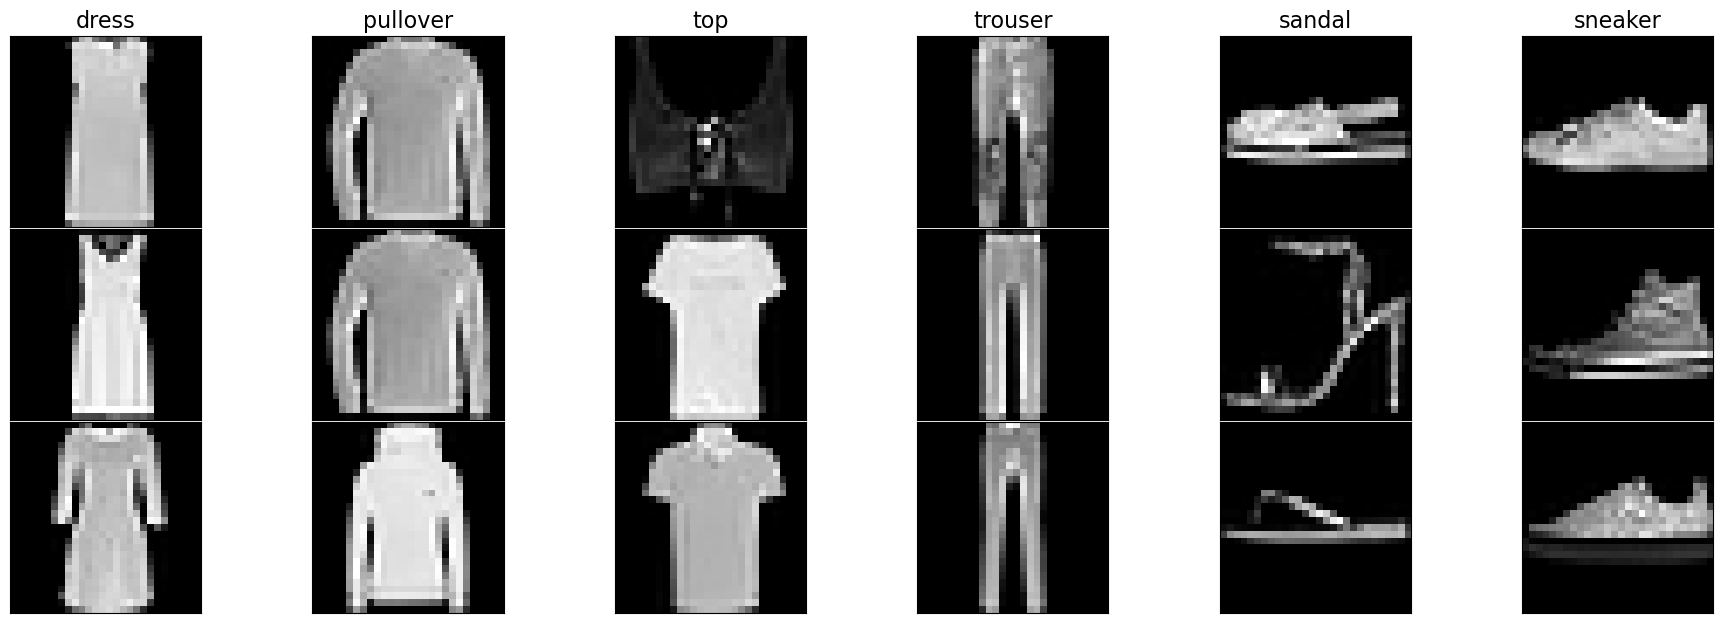

In [3]:
%run load_and_plot_data.py

In [4]:
train_y = np.array(train_y_df['class_uid'])
valid_y = np.array(valid_y_df['class_uid'])
train_x = train_x
valid_x = valid_x
train_y.shape, valid_y.shape

((2102,), (600,))

In [5]:
train_x.shape, train_x[0].dtype

((2102, 784), dtype('int64'))

## Data Proprocessing with Normalization

In [6]:
normed_train_x = normed_train_x = sklearn.preprocessing.normalize(train_x, norm = 'max', axis = 1)
normed_valid_x = sklearn.preprocessing.normalize(valid_x, norm = 'l1', axis = 1)


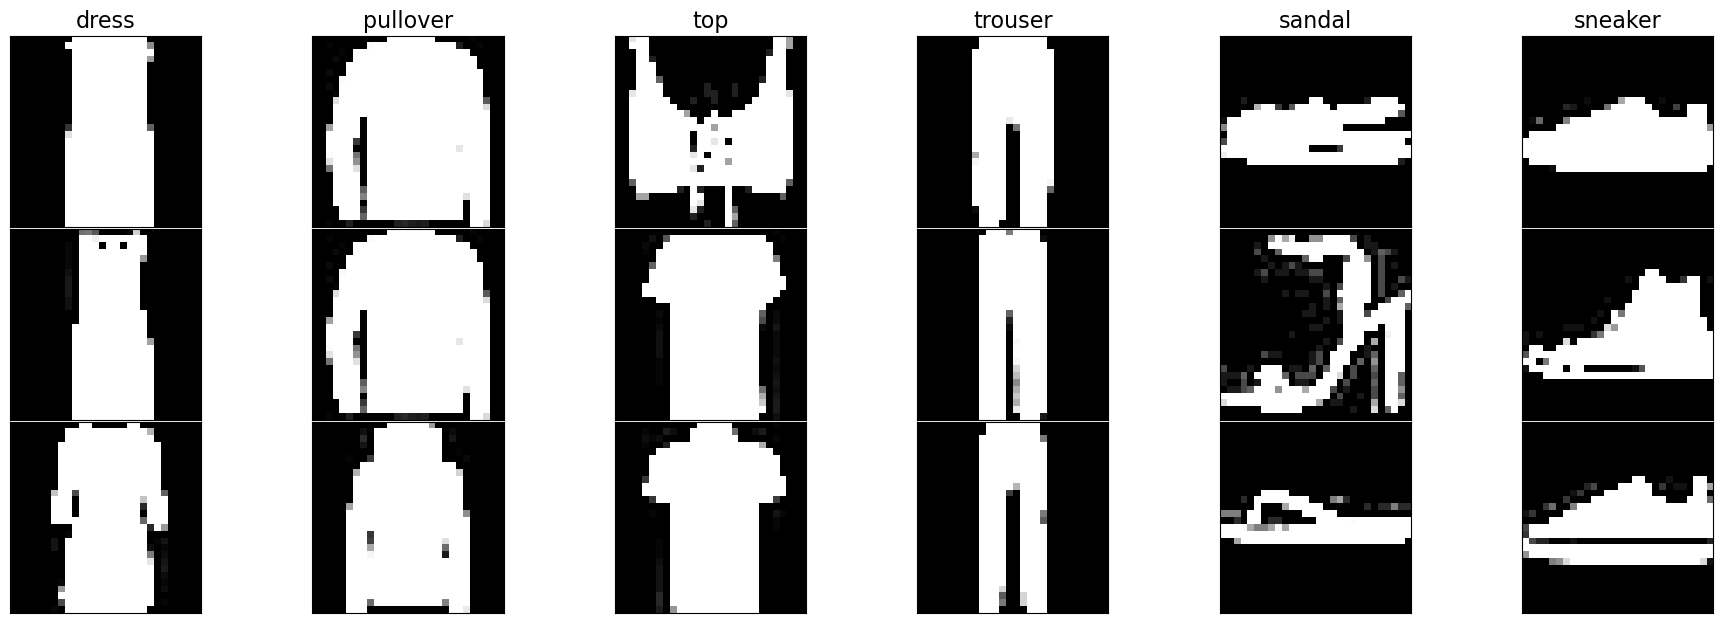

In [7]:
prng = np.random.RandomState(0)
N = 3 # num examples of each class to show
fig, axgrid = plt.subplots(N, 6, figsize=(6*3, N*2.5))

for ll, label in enumerate(['dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker']):
    match_df = valid_y_df.query("class_name == '%s'" % label)
    match_ids_N = prng.choice(match_df.index, size=N)        
    for ii, row_id in enumerate(match_ids_N):
        ax = axgrid[ii, ll]
        x_SS = normed_valid_x[row_id].reshape((28,28))
        ax.imshow(x_SS, vmin=0, vmax=255/normed_valid_x.shape[0]/normed_valid_x[0].shape[0], cmap='gray')
        ax.set_xticks([]); ax.set_yticks([]);
        if ii == 0:
            ax.set_title(label, fontsize=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=.2, hspace=.01)
#plt.tight_layout();
plt.show();

## Data Augmentation

In [41]:
## Horizontal Flip
num_rows_to_flip = 400

# Generate random indices to select rows for flipping
selected_indices_tr = np.random.choice(normed_train_x.shape[0], num_rows_to_flip, replace=False)
aug_tr = np.copy(normed_train_x)
aug_tr[selected_indices_tr] = np.flip(aug_tr[selected_indices_tr], axis=1)

if not np.isclose(np.sum(aug_tr[selected_indices_tr[0]]), np.sum(normed_train_x[selected_indices_tr[0]]), atol = 1e-8):
    warnings.warn('Flip Failed!')

In [67]:
## Translation
n = 1e-3 # the extent of translation
aug_tr = np.copy(normed_train_x)
num_rows_to_translate = 500 # max = 2101
num_cols_to_translate = 784 # max = 784

selected_rows = np.random.choice(aug_tr.shape[0], num_rows_to_translate, replace=False)
selected_cols = np.random.choice(aug_tr.shape[1], num_cols_to_translate, replace=False)

translated_array = np.copy(aug_tr)

for row, col in zip(selected_rows, selected_cols):
    alter_range = np.random.uniform(n, n)
    translated_array[row, col] += np.random.choice([-1, 1]) * alter_range 

    
aug_tr = translated_array

if not np.isclose(aug_tr[selected_rows[0],selected_cols[0]] - normed_train_x[selected_rows[0],selected_cols[0]],0.00 , atol = 1):
    warnings.warn('Translation Failed')
    
# np.sum(aug_tr - normed_train_x)

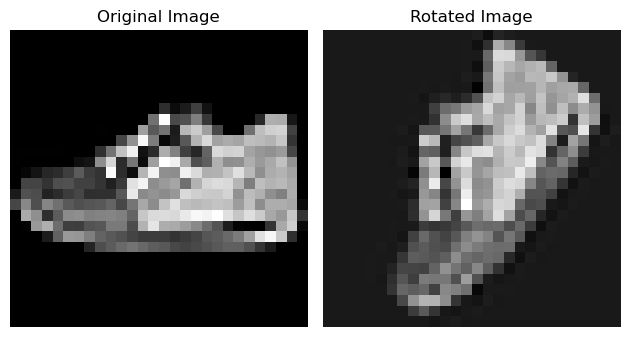

In [136]:
## Rotation
from scipy.ndimage import rotate

aug_tr = np.copy(normed_train_x)
num_rows_to_rotate = 200 # max = 2102

selected_indices = np.random.choice(aug_tr.shape[0], num_rows_to_rotate, replace=False)
rotated_array = np.copy(aug_tr)

for row in selected_indices:
    # Randomly rotate elements within the row
    random_angle = np.random.randint(360)  # Choose a random angle between 0 and 360 degrees
    rotated_array[row] = rotate(rotated_array[row].reshape(28,28), random_angle, reshape=False).reshape(784,)
    
    
aug_tr = rotated_array
aug_tr[selected_indices[0]] - normed_train_x[selected_indices[0]]

plt.subplot(1, 2, 1)
plt.imshow(normed_train_x[selected_indices[0]].reshape(28,28), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(aug_tr[selected_indices[0]].reshape(28,28), cmap='gray')
plt.title('Rotated Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [96]:
mlp = MLPClassifier(
            activation='relu',
            # solver='lbfgs',
            # batch_size=100000,
            momentum=0.0,
            # tol=1e-4,
            )
n = 8
random_states = np.random.randint(1, 1000, size=n)

In [10]:
random_states

array([407,  31, 347, 825,  81, 250, 775, 294])

In [36]:
# mlp_hyperparameter_grid = dict(
#     hidden_layer_sizes = [ (16, ), (32, ), (40, ), (80, ) ], 
#     max_iter= [25, 40, 100],
#     random_state = random_states,
#     alpha= [1e-1, 1e-2, 1e-3, 1e-5, 1e-10]#[1e-1, 1e-2, 1e-3, 1e-4, 1e-5] #[1e-2, 1e-10] 
#     )

mlp_hyperparameter_grid = {
    'hidden_layer_sizes': [(25,),(50,), (100,), (150,)],  # Expanded hidden layer sizes
    'alpha': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],  # Adjusted alpha values for regularization
    'max_iter': [50, 100, 150],  # Expanded max iterations
    'tol': [1e-4, 1e-5, 1e-6],  # More refined tolerance levels
    'solver': ['lbfgs'],  # Try different solvers
    'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule options
    # Add more parameters related to architecture, batch size, or dropout if needed
}

# Hyperparameter Search

In [37]:
xall = np.vstack([normed_train_x, normed_valid_x])
yall = np.hstack([train_y, valid_y])

### splitter
valid_indicators_L = np.hstack([
    -1 * np.ones(train_y.size), # -1 means never include this example in any test split
    0  * np.ones(valid_y.size), #  0 means include in the first test split (we count starting at 0 in python)
    ])
my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators_L)

In [38]:
mlp_searcher = sklearn.model_selection.GridSearchCV(estimator = mlp,
                                                    param_grid = mlp_hyperparameter_grid,
                                                    scoring = 'balanced_accuracy',
                                                    cv = my_splitter,
                                                    return_train_score = True,
                                                    refit=True
                                                   )

In [ ]:
start_time_sec = time.time()
mlp_searcher.fit(xall, yall)
elapsed_time_sec = time.time() - start_time_sec

In [ ]:
mlp_searcher_result = pd.DataFrame(mlp_searcher.cv_results_).copy()
mlp_searcher_result

In [ ]:
idx = np.argmax(mlp_searcher_result.mean_test_score)
mlp_searcher_result.params[idx]

In [ ]:
mi = mlp_searcher_result.params[idx]['max_iter']
hlz = mlp_searcher_result.params[idx]['hidden_layer_sizes']
a = mlp_searcher_result.params[idx]['alpha']
mi, hlz

In [46]:
mean_results = mlp_searcher_result.mean_test_score
mean_results = np.array(mean_results)
mean_results = np.reshape(mean_results, (mean_results.shape[0]//n ,n))
mean_results = np.mean(mean_results, axis=1)
mean_results

array([0.65645833, 0.65270833, 0.67104167, 0.663125  , 0.66104167,
       0.676875  , 0.6675    , 0.66208333, 0.67083333, 0.658125  ,
       0.66541667, 0.659375  , 0.66520833, 0.66229167, 0.66895833,
       0.66145833, 0.65979167, 0.65666667, 0.67875   , 0.66041667,
       0.66895833, 0.67604167, 0.67125   , 0.67104167, 0.65625   ,
       0.66375   , 0.67041667, 0.67145833, 0.64958333, 0.67854167,
       0.6675    , 0.65854167, 0.66666667, 0.66229167, 0.6775    ,
       0.65979167, 0.65333333, 0.669375  , 0.665     , 0.66541667,
       0.666875  , 0.66041667, 0.66541667, 0.68416667, 0.67041667])

In [25]:
t = np.argmax(mean_results)
print(t,np.max(mean_results))
mlp_searcher_result.params[t*n]

8 0.6433333333333333


{'alpha': 0.001,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'adaptive',
 'max_iter': 100,
 'solver': 'lbfgs',
 'tol': 1e-05}

In [26]:
mi = 100
hlz = (100,)
a = 0.001

# get the average of all the results
desired_runs = []

for i in range(mlp_searcher_result.shape[0]):
    params = mlp_searcher_result.params[i]
    if params['max_iter'] == mi and params['hidden_layer_sizes'] == hlz and params['alpha'] == a:
        desired_runs.append(i)

# Print or process the desired runs
results = []
for run in desired_runs:
    r = mlp_searcher_result.mean_test_score[run]
    print(r)
    results.append(r)

np.mean(results)


0.5433333333333333
0.49499999999999994
0.5266666666666667
0.71
0.6616666666666666
0.6533333333333333
0.5533333333333333
0.5166666666666667
0.535
0.66
0.6566666666666666
0.6666666666666666


0.5981944444444445

In [27]:
# best_param = mlp_searcher.best_params_
manual_param = {'alpha': 0.001,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'adaptive',
 'max_iter': 100,
 'solver': 'lbfgs',
 'tol': 1e-05}

In [28]:
best_mlp = mlp 
best_mlp.set_params(**manual_param)
best_mlp.fit(normed_train_x, train_y)

MLPClassifier(alpha=0.001, learning_rate='adaptive', max_iter=100, momentum=0.0,
              solver='lbfgs', tol=1e-05)

In [29]:
pred_y = best_mlp.predict(normed_valid_x)
best_mlp_BAcc = sklearn.metrics.balanced_accuracy_score(valid_y, pred_y)
best_mlp_BAcc

0.6649999999999999

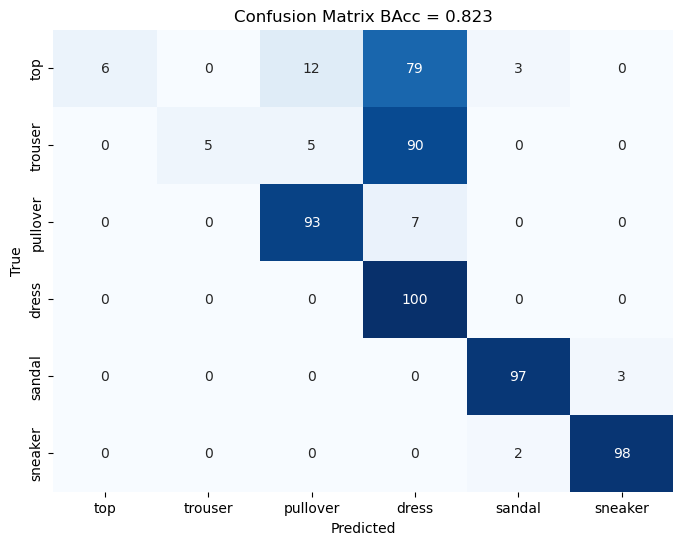

In [30]:
conf_matrix = confusion_matrix(valid_y, pred_y)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['top', 'trouser', 'pullover', 'dress', 'sandal', 'sneaker'],
            yticklabels=['top', 'trouser', 'pullover', 'dress', 'sandal', 'sneaker'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix BAcc = 0.823')
plt.show()